# Set up notebook

In [1]:
%load_ext rpy2.ipython

## r libraries

In [2]:
%%R
library(dplyr)
library(Seurat)
library(patchwork)
library(data.table)
library(DropletUtils)
library(scRNAseq)
library(scater)
library(scran)
library(PCAtools)
set.seed(110010101)

path_to <- "VSG-2_VSG-6_1_count6/outs/"

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Attaching SeuratObject

R[write to console]: data.table 1.14.2 using 32 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: 
Attaching package: ‘data.table’


R[write to console]: The following objects are masked from ‘package:dplyr’:

    between, first, last


R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘matrixStats’


R[write to console]: The following object is masked from ‘package:dplyr’:

    count


R[write to console

## python libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import seaborn as sns

path_to = "VSG-2_VSG-6_1_count6/outs/"

## Estimate and remove Background

R[write to console]: Loading raw count data

R[write to console]: Loading cell-only count data

R[write to console]: Loading extra analysis data where available

R[write to console]: 9 genes passed tf-idf cut-off and 7 soup quantile filter.  Taking the top 7.

R[write to console]: Using 19 independent estimates of rho.

R[write to console]: Estimated global rho of 0.28

R[write to console]: Expanding counts from 9 clusters to 5492 cells.



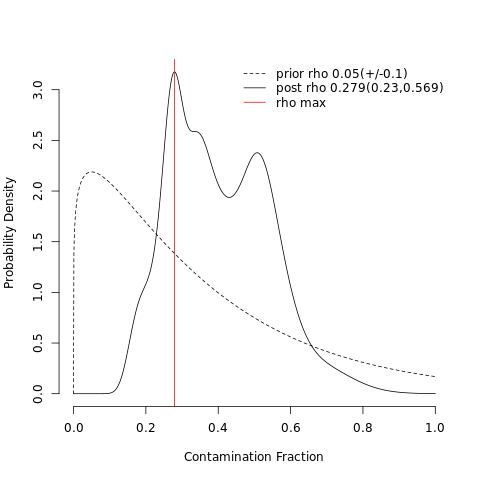

In [4]:
%%R
library(SoupX)
sce = load10X('VSG-2_VSG-6_1_count6/outs/')
sce = autoEstCont(sce, tfidfMin=0.85, forceAccept=TRUE)#, priorRhoStdDev = 0.3
out = adjustCounts(sce, roundToInt=TRUE)

In [5]:
%%R
head(sce$soupProfile[order(sce$soupProfile$est, decreasing = TRUE), ], n = 20)
#head(sce$soupProfile)

                             est counts
vsg-6-Tb427.BES15.12 0.032999482  45261
vsg-2-Tb427.BES40.22 0.016225966  22255
rRNA-Tb927.2.1975    0.014208566  19488
Tb927.1.2390         0.005328212   7308
Tb927.5.1810         0.003253942   4463
Tb11.v5.0381         0.002195299   3011
Tb11.v5.0498         0.002138430   2933
maxic-12S            0.002053855   2817
Tb927.10.8940        0.001793569   2460
Tb927.3.3270         0.001789194   2454
Tb11.1810b           0.001758572   2412
Tb927.11.9590        0.001710452   2346
Tb11.v5.0632         0.001425377   1955
Tb927.6.4280         0.001391839   1909
Tb927.10.10000       0.001320388   1811
Tb927.2.370          0.001290495   1770
Tb927.5.810          0.001257686   1725
Tb927.8.7410         0.001243833   1706
Tb927.11.880         0.001239458   1700
Tb927.11.7510        0.001232896   1691


In [6]:
#%%R
#plotMarkerDistribution(sce)

In [7]:
#Tb927.1.2390 beta tubulin
#Tb927.1.2390 ysosomal/endosomal membrane protein p67
#Tb11.v5.0498 lysosomal alpha-mannosidase precursor, putative
#Tb927.10.8940 flagellum targeting protein kharon1, putative
#Tb927.3.3270 ATP-dependent 6-phosphofructokinase, glycosomal

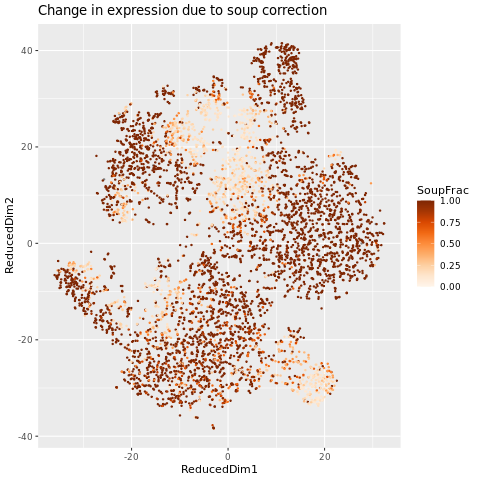

In [8]:
%%R
plotChangeMap(sce, out, "vsg-6-Tb427.BES15.12")

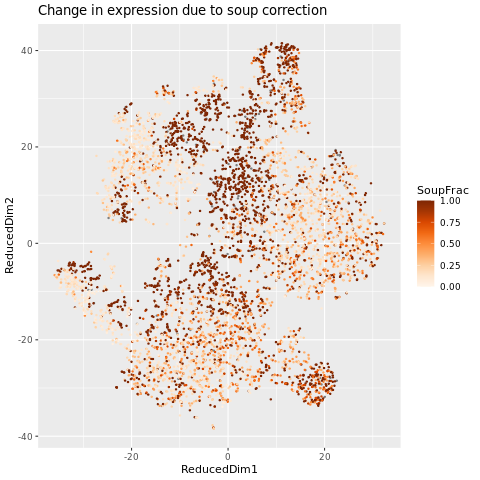

In [9]:
%%R
plotChangeMap(sce, out, "vsg-2-Tb427.BES40.22")

In [10]:
#%%R
#vsgGenes = c("vsg-6-Tb427.BES15.12", "vsg-2-Tb427.BES40.22")
#useToEst = estimateNonExpressingCells(sce, nonExpressedGeneList = list(vsgGenes = vsgGenes))
#sce = calculateContaminationFraction(sce, list(vsgGenes = vsgGenes), useToEst = useToEst)

In [11]:
#%%R
#sce = calculateContaminationFraction(sce, 
#                                     list(vsgGenes = vsgGenes), 
#                                     useToEst = useToEst, forceAccept=TRUE)

In [12]:
#%%R
#plotMarkerDistribution(sce)

# Load dataset

In [13]:
%%R
sce <- SingleCellExperiment(assays = list(counts = out))
sce

class: SingleCellExperiment 
dim: 11497 5492 
metadata(0):
assays(1): counts
rownames(11497): gene-Tb427.BES40.1 gene-Tb427.BES40.2 ... Tb11.1770
  Tb11.1800
rowData names(0):
colnames(5492): AAACCCAAGACACACG-1 AAACCCAAGCTTTCCC-1 ...
  TTTGTTGAGGCCGCTT-1 TTTGTTGTCCAAGAGG-1
colData names(0):
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [14]:
%%R
assayNames(sce)

[1] "counts"


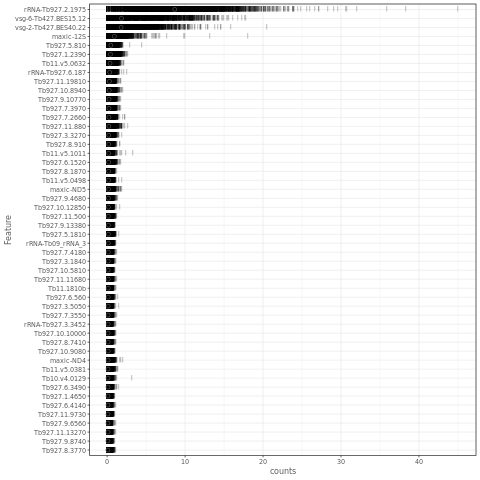

In [15]:
%%R
plotHighestExprs(sce, exprs_values = "counts")

In [16]:
#%%R
#counts(sce) <- assay(sce, "decontXcounts")

# Add QC 
Default testing sum and detected transcripts plus:
- maxicircle
- ribosomal RNA
- VSGs

In [17]:
%%R
is.mito <- grepl("^maxic", rownames(sce))
is.vsg <- grepl("^vsg-", rownames(sce))
is.Ribo <-grepl("^rRNA-", rownames(sce)) 
df <- perCellQCMetrics(counts(sce), subsets=list(Mito=is.mito, VSG=is.vsg, Ribo=is.Ribo))
head(df)

DataFrame with 6 rows and 11 columns
                         sum  detected subsets_Mito_sum subsets_Mito_detected
                   <numeric> <integer>        <numeric>             <integer>
AAACCCAAGACACACG-1       460       361               15                     7
AAACCCAAGCTTTCCC-1       575       483                6                     3
AAACCCACAAGCTACT-1       499       380                6                     2
AAACCCATCCTCTGCA-1       762       529               10                     4
AAACGAACATCATTGG-1       903       550               13                     3
AAACGAAGTACAAGTA-1       550       433                3                     2
                   subsets_Mito_percent subsets_VSG_sum subsets_VSG_detected
                              <numeric>       <numeric>            <integer>
AAACCCAAGACACACG-1             3.260870              40                    2
AAACCCAAGCTTTCCC-1             1.043478              17                    1
AAACCCACAAGCTACT-1             

In [18]:
%%R
sum(is.Ribo)

[1] 104


# Test x outlayers

In [19]:
%%R
# not too high / not too low
qc.lib2 <- isOutlier(df$sum, nmads = 2, log=TRUE, type="both")
qc.nexprs2 <- isOutlier(df$detected, nmads = 2, log=TRUE, type="both")
qc.vsg2 <- isOutlier(df$subsets_VSG_percent, nmads = 2, type="both")

# not too high
qc.mito2 <- isOutlier(df$subsets_Mito_percent, nmads = 3, type="higher")
qc.ribo2 <- isOutlier(df$subsets_Ribo_percent, nmads = 3, type="higher")

discard2 <- qc.lib2 | qc.nexprs2 | qc.mito2 | qc.ribo2 | qc.vsg2
sum(discard2)

[1] 851


## add discarded info to the sce object

In [20]:
%R sce$discard_mito <- qc.mito2
%R sce$discard_sum <- qc.lib2
%R sce$discard_detect <- qc.nexprs2
%R sce$discard_vsg <- qc.vsg2
%R sce$discard_ribo <- qc.ribo2
%R sce$discard_all <- discard2

0,0,0,...,0,0,0


## quick add qc to sce

In [21]:
%%R
sce <- addPerCellQC(sce, subsets=list(Mito=is.mito, VSG=is.vsg, Ribo=is.Ribo))
sce

class: SingleCellExperiment 
dim: 11497 5492 
metadata(0):
assays(1): counts
rownames(11497): gene-Tb427.BES40.1 gene-Tb427.BES40.2 ... Tb11.1770
  Tb11.1800
rowData names(0):
colnames(5492): AAACCCAAGACACACG-1 AAACCCAAGCTTTCCC-1 ...
  TTTGTTGAGGCCGCTT-1 TTTGTTGTCCAAGAGG-1
colData names(18): discard_mito discard_sum ... subsets_Ribo_percent
  total
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


## Visualize Discarded
### by mito

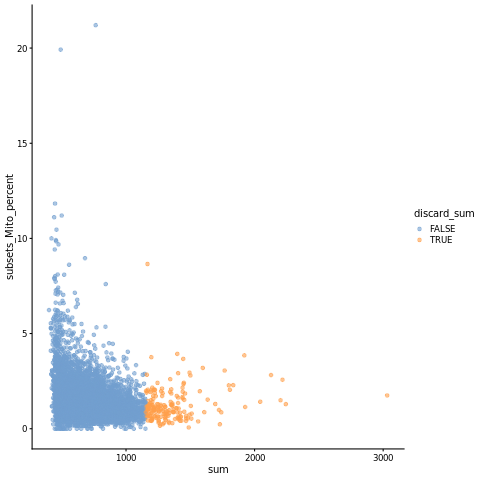

In [22]:
%%R
plotColData(sce, x="sum", y="subsets_Mito_percent", colour_by="discard_sum")

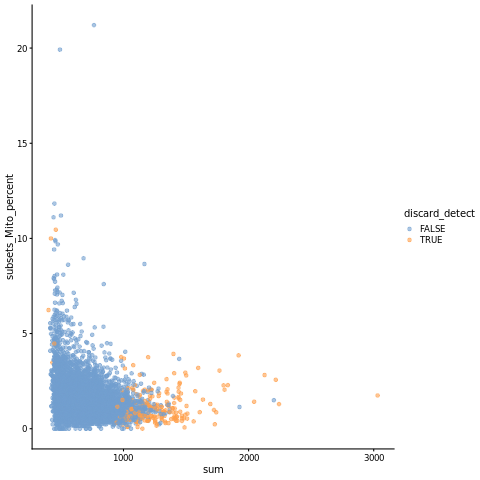

In [23]:
%%R
plotColData(sce, x="sum", y="subsets_Mito_percent", colour_by="discard_detect")

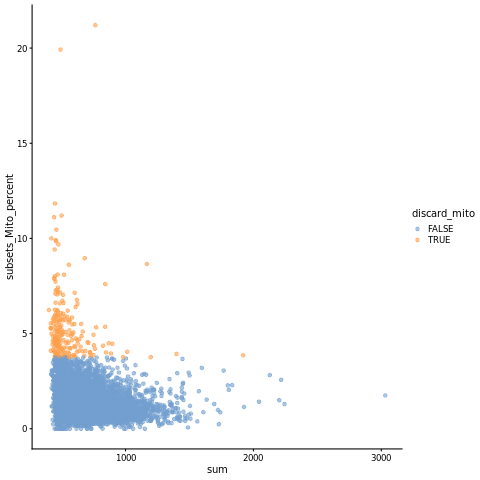

In [24]:
%%R
plotColData(sce, x="sum", y="subsets_Mito_percent", colour_by="discard_mito")

In [25]:
#%%R
#plotColData(sce, x="sum", y="subsets_Mito_percent", colour_by="discard_vsg")

In [26]:
#%%R
#plotColData(sce, x="sum", y="subsets_Mito_percent", colour_by="discard_ribo")

### by VSG

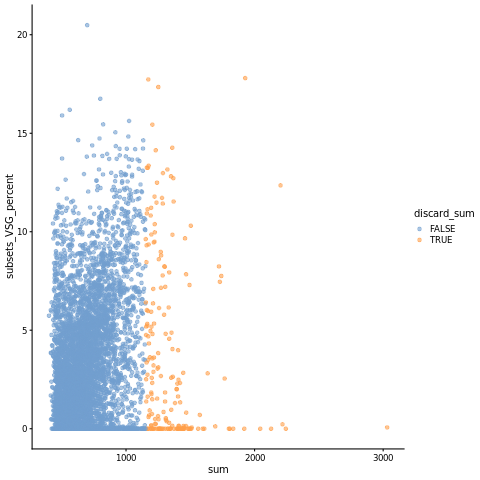

In [27]:
%%R
plotColData(sce, x="sum", y="subsets_VSG_percent", colour_by="discard_sum")

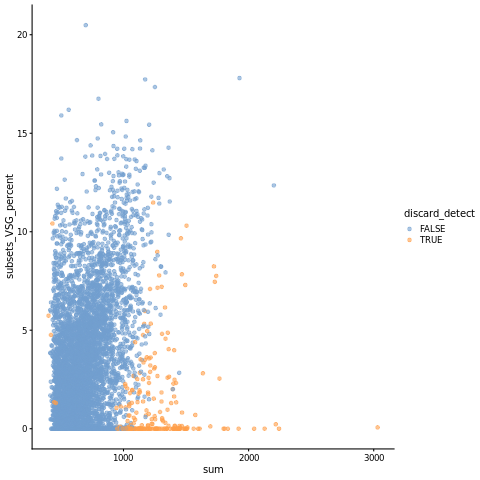

In [28]:
%%R
plotColData(sce, x="sum", y="subsets_VSG_percent", colour_by="discard_detect")

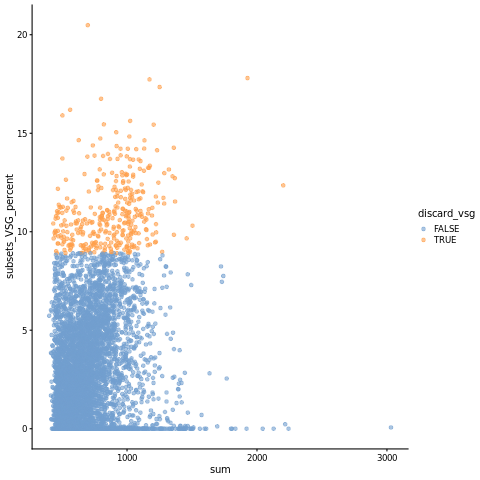

In [29]:
%%R
plotColData(sce, x="sum", y="subsets_VSG_percent", colour_by="discard_vsg")

In [30]:
#%%R
#plotColData(sce, x="sum", y="subsets_VSG_percent", colour_by="discard_mito")

In [31]:
#%%R
#plotColData(sce, x="sum", y="subsets_VSG_percent", colour_by="discard_ribo")

### by Ribo

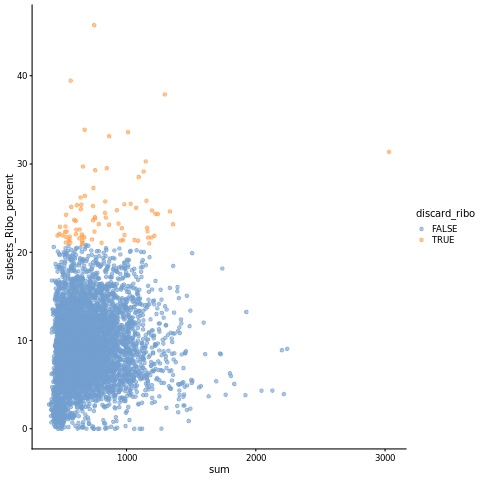

In [32]:
%%R
plotColData(sce, x="sum", y="subsets_Ribo_percent", colour_by="discard_ribo")

### all

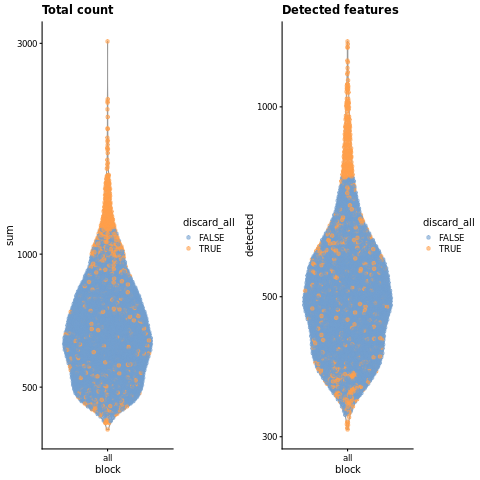

In [33]:
%%R
#colData(sce.416b) <- cbind(colData(sce.416b), df)
sce$block <- factor(rep('all',nrow(df)))


gridExtra::grid.arrange(
    plotColData(sce, x="block", y="sum", colour_by="discard_all") + 
        scale_y_log10() + ggtitle("Total count"),
    plotColData(sce, x="block", y="detected", colour_by="discard_all")+
        scale_y_log10() + ggtitle("Detected features"),
    
    #plotColData(sce, x="block", y="subsets_Mito_percent", colour_by="discard_all")+
    #    scale_y_log10() + ggtitle("Detected features"),


    
    nrow=1
    
)

In [34]:
#%%R
#library(repr)
#fig <- function(){
#    par(mfrow=c(1,2))
#    #options(repr.plot.width = 12, repr.plot.height = 3)
#    hist(
#        sce$total,
#        breaks = 100)
    
#    hist(
#        sce$detected,
#        breaks = 100)
    
# }
#fig()

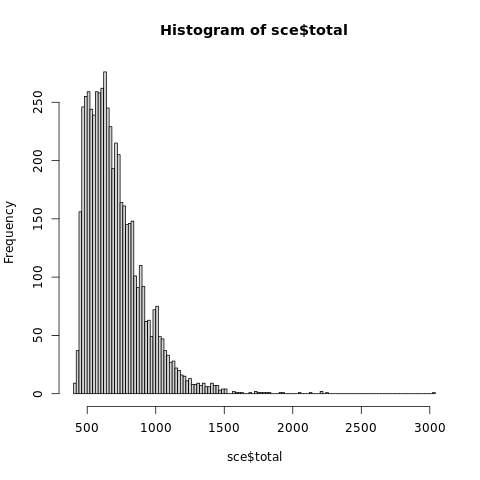

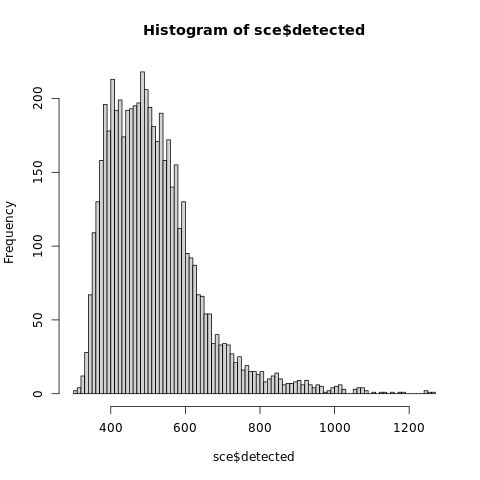

In [35]:
%%R

hist(
    sce$total,
    breaks = 100)

hist(
    sce$detected,
    breaks = 100)

In [36]:
#%%R
#min(sce$total)

# Library size before filtering

In [37]:
%%R
lib.size <- librarySizeFactors(sce)
summary(lib.size)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5676  0.7841  0.9356  1.0000  1.1422  4.2900 


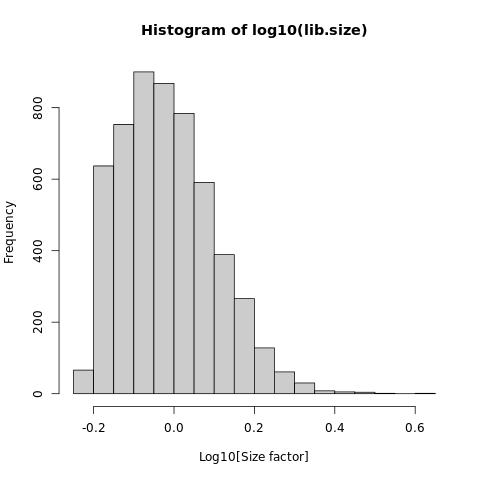

In [38]:
%%R
hist(log10(lib.size), xlab="Log10[Size factor]", col='grey80')

# Library size after filtering

In [39]:
%%R
sce <- sce[, which(!discard2)]
sce

class: SingleCellExperiment 
dim: 11497 4641 
metadata(0):
assays(1): counts
rownames(11497): gene-Tb427.BES40.1 gene-Tb427.BES40.2 ... Tb11.1770
  Tb11.1800
rowData names(0):
colnames(4641): AAACCCAAGACACACG-1 AAACCCAAGCTTTCCC-1 ...
  TTTGTTGAGGCCGCTT-1 TTTGTTGTCCAAGAGG-1
colData names(19): discard_mito discard_sum ... total block
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [40]:
%%R
sum(is.Ribo)

[1] 104


In [41]:
%%R
sum(is.mito)

[1] 14


In [42]:
#%%R
#sce <- sce[which(!combine_del), ]
#sce

In [43]:
%%R
lib.size <- librarySizeFactors(sce)
summary(lib.size)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6236  0.8215  0.9629  1.0000  1.1445  1.7130 


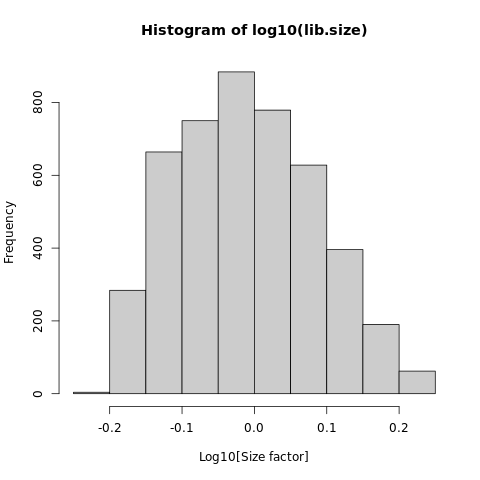

In [44]:
%%R
hist(log10(lib.size), xlab="Log10[Size factor]", col='grey80')

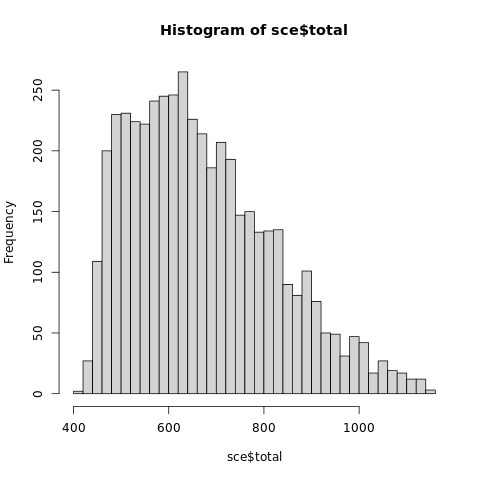

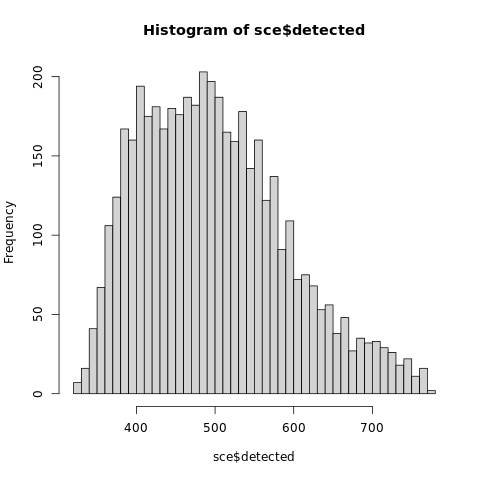

In [45]:
%%R
hist(
    sce$total,
    breaks = 50)

hist(
    sce$detected,
    breaks = 50)

In [46]:
%%R
assayNames(sce)

[1] "counts"


# Adjust for library size

In [47]:
%%R
clust.sce <- quickCluster(sce)
sce <- computeSumFactors(sce, cluster=clust.sce, min.mean=0.1)
sce <- logNormCounts(sce)
assayNames(sce)

[1] "counts"    "logcounts"


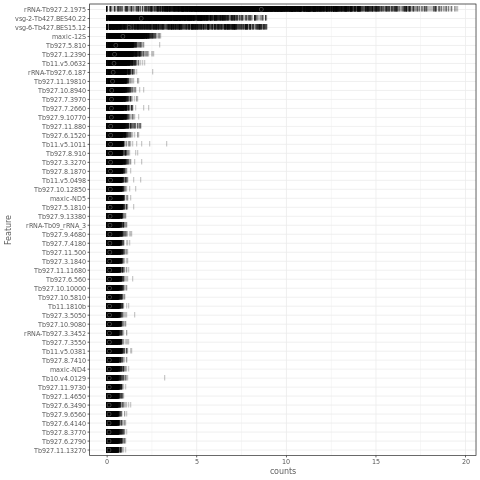

In [48]:
%%R
plotHighestExprs(sce, exprs_values = "counts")

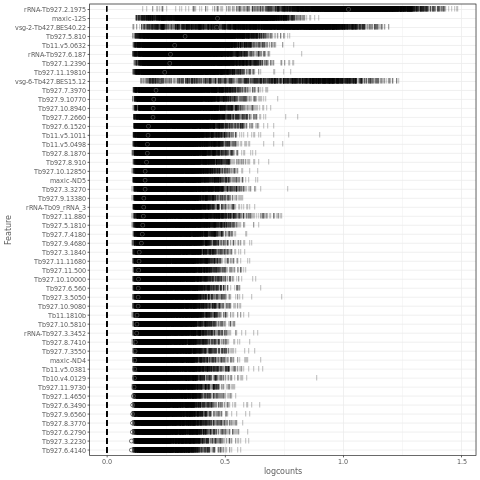

In [49]:
%%R
plotHighestExprs(sce, exprs_values = "logcounts")

In [50]:
%%R

combine_del <- is.mito | is.Ribo
sum(combine_del)

sce <- sce[which(!combine_del), ]
sce

class: SingleCellExperiment 
dim: 11379 4641 
metadata(0):
assays(2): counts logcounts
rownames(11379): gene-Tb427.BES40.1 gene-Tb427.BES40.2 ... Tb11.1770
  Tb11.1800
rowData names(0):
colnames(4641): AAACCCAAGACACACG-1 AAACCCAAGCTTTCCC-1 ...
  TTTGTTGAGGCCGCTT-1 TTTGTTGTCCAAGAGG-1
colData names(20): discard_mito discard_sum ... block sizeFactor
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


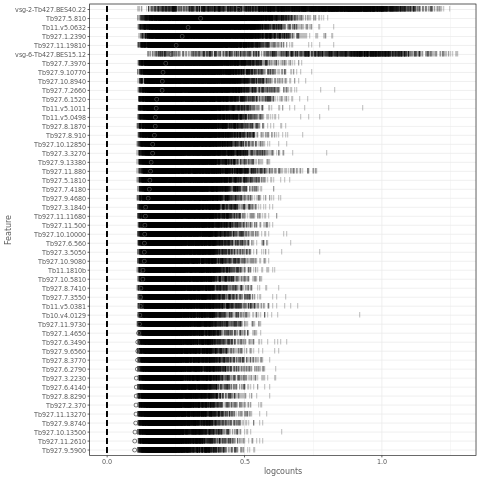

In [51]:
%%R
plotHighestExprs(sce, exprs_values = "logcounts")

# Visualize CV

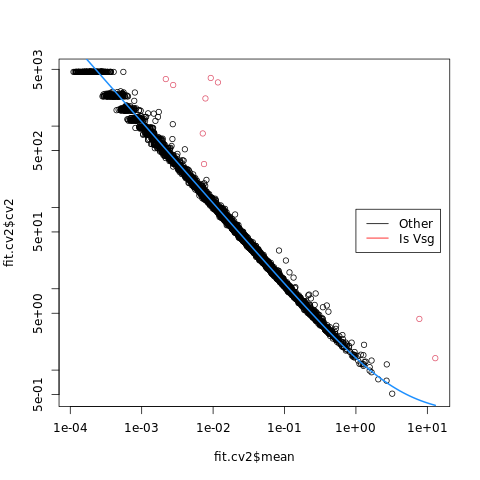

In [52]:
%%R
is.vsg2 <- grepl("^vsg-", rownames(sce))
length(is.vsg2)

dec.cv2 <- modelGeneCV2(sce)
fit.cv2 <- metadata(dec.cv2)
plot(fit.cv2$mean, fit.cv2$cv2, log="xy", col=is.vsg2+1)
curve(fit.cv2$trend(x), col="dodgerblue", add=TRUE, lwd=2)
legend(1, 95, legend=c("Other", "Is Vsg"),col=c("black", "red"),lty=1:1)

# Poisson Modeling

In [53]:
%%R 
dec.pois <- modelGeneVarByPoisson(sce)
dec.pois <- dec.pois[order(dec.pois$bio, decreasing=TRUE),]
head(dec.pois)

DataFrame with 6 rows and 6 columns
                          mean     total      tech       bio   p.value
                     <numeric> <numeric> <numeric> <numeric> <numeric>
vsg-2-Tb427.BES40.22  2.582181  4.427357  0.365621  4.061735         0
vsg-6-Tb427.BES15.12  1.252864  4.289276  0.578096  3.711180         0
Tb927.1.2390          1.476176  1.220729  0.571457  0.649272         0
Tb927.11.880          0.853745  0.894420  0.527819  0.366601         0
Tb927.10.8940         1.085436  0.915037  0.567570  0.347467         0
Tb11.v5.0632          1.592168  0.898315  0.558438  0.339877         0
                           FDR
                     <numeric>
vsg-2-Tb427.BES40.22         0
vsg-6-Tb427.BES15.12         0
Tb927.1.2390                 0
Tb927.11.880                 0
Tb927.10.8940                0
Tb11.v5.0632                 0


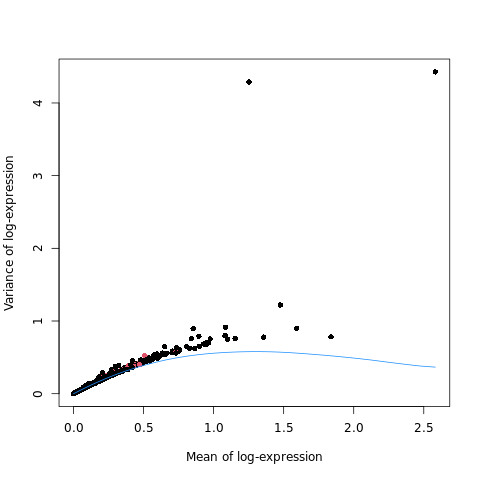

In [54]:
%%R 
plot(dec.pois$mean, dec.pois$total, pch=16, xlab="Mean of log-expression",
    ylab="Variance of log-expression", col=is.vsg2+1)
curve(metadata(dec.pois)$trend(x), col="dodgerblue", add=TRUE)

# Select top variable

In [55]:
%%R 
hvg.var <- getTopHVGs(dec.pois,n=200)# fdr.threshold=0.000000001)
length(hvg.var)

[1] 200


In [56]:
%%R
rownames(sce[which(is.vsg2), ])

 [1] "vsg-2-Tb427.BES40.22"   "vsg-9-Tb427.BES129.14"  "vsg-6-Tb427.BES15.12"  
 [4] "vsg-21-Tb427.BES28.15"  "vsg-18-Tb427.BES98.12"  "vsg-3-Tb427.BES65.13"  
 [7] "vsg-14-Tb427.BES64.2"   "vsg-15-Tb427.BES134.6"  "vsg-16-Tb427.BES122.11"
[10] "vsg-8-Tb427.BES29.9"    "vsg-17-Tb427.BES56.13"  "vsg-19-Tb427.BES10.10" 
[13] "vsg-11-Tb427.BES126.15" "vsg-13-Tb427.BES51.12"  "vsg-mes-Tb427VSG-397"  
[16] "vsg-mes-Tb427VSG-531"   "vsg-mes-Tb427VSG-639"   "vsg-mes-Tb427VSG-653"  
[19] "vsg-mes-Tb427VSG-1954"  "vsg-mes-Tb427VSG-636"   "vsg-mes-Tb427VSG-559"  
[22] "vsg-mes-Tb427VSG-3591" 


# Dimensionality Reduction

In [57]:
%%R 
head(hvg.var)

[1] "vsg-2-Tb427.BES40.22" "vsg-6-Tb427.BES15.12" "Tb927.1.2390"        
[4] "Tb927.11.880"         "Tb927.10.8940"        "Tb11.v5.0632"        


In [58]:
#%%R
##to install
##https://bioconductor.org/books/release/OSCA/dimensionality-reduction.html#overview-2
#percent.var <- attr(reducedDim(sce), "percentVar")
#chosen.elbow <- PCAtools::findElbowPoint(percent.var)
#chosen.elbow

In [59]:
%%R
sce <- runPCA(sce, subset_row=hvg.var) 
reducedDimNames(sce)

[1] "PCA"


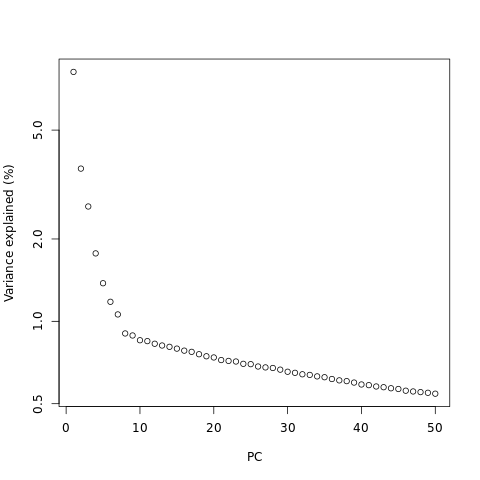

In [60]:
%%R 
percent.var <- attr(reducedDim(sce), "percentVar")
plot(percent.var, log="y", xlab="PC", ylab="Variance explained (%)")

In [61]:
%%R 
# Percentage of variance explained is tucked away in the attributes.
percent.var <- attr(reducedDim(sce), "percentVar")
chosen.elbow <- PCAtools::findElbowPoint(percent.var)
chosen.elbow

[1] 5


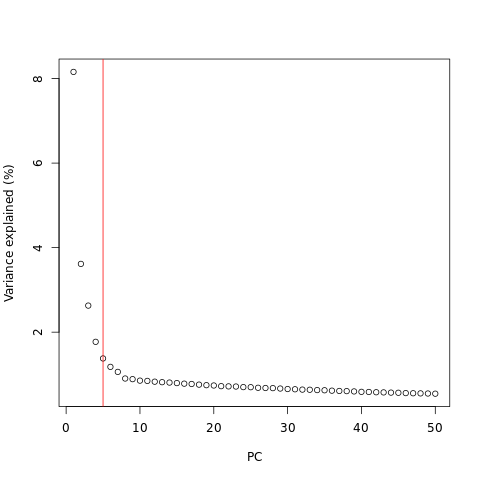

In [62]:
%%R
plot(percent.var, xlab="PC", ylab="Variance explained (%)")
abline(v=chosen.elbow, col="red")

In [63]:
%%R
sce <- runPCA(sce, subset_row=hvg.var, ncomponents = 5)

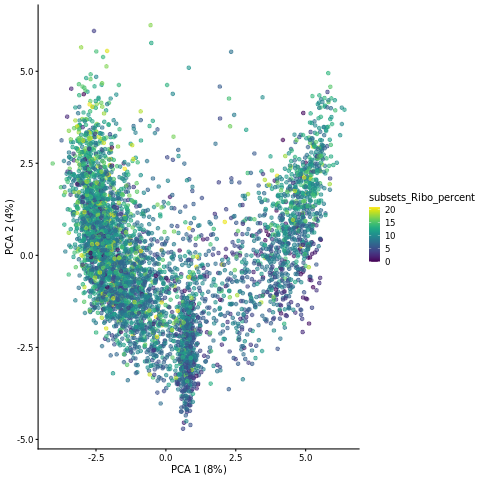

In [64]:
%%R
plotReducedDim(sce, dimred="PCA", colour_by="subsets_Ribo_percent")

R[write to console]: 
Attaching package: 'celda'


R[write to console]: The following objects are masked from 'package:scater':

    normalizeCounts, plotHeatmap


R[write to console]: The following object is masked from 'package:scuttle':

    normalizeCounts


R[write to console]: The following object is masked from 'package:S4Vectors':

    params




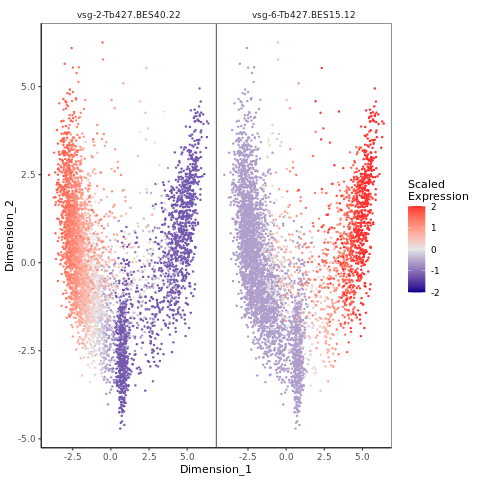

In [65]:
%%R
library(celda)
umap <- reducedDim(sce, "PCA")
plotDimReduceFeature(as.matrix(logcounts(sce)),
    dim1 = umap[, 1],
    dim2 = umap[, 2],
    features = c('vsg-2-Tb427.BES40.22', 'vsg-6-Tb427.BES15.12'),
    exactMatch = TRUE)

In [66]:
#%%R 
#sce <- runTSNE(sce, dimred="PCA", perplexity=200)
#plotReducedDim(sce, dimred="TSNE", colour_by="subsets_Mito_percent")

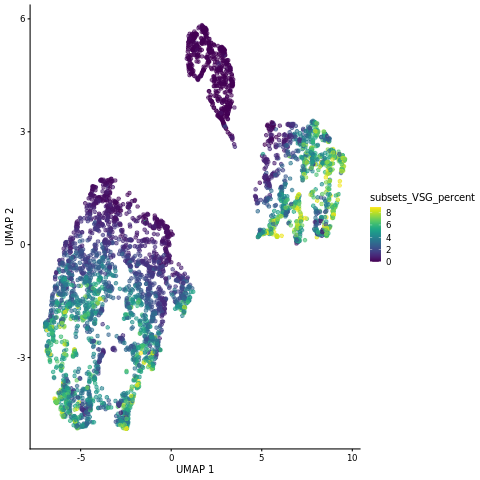

In [67]:
%%R
sce <- runUMAP(sce, dimred="PCA")
plotReducedDim(sce, dimred="UMAP", colour_by="subsets_VSG_percent")

In [68]:
%%R
clust.kmeans <- kmeans(reducedDim(sce, "UMAP"), centers=3)
table(clust.kmeans$cluster)

#nn.clusters <- clusterCells(sce, use.dimred="PCA")
#table(nn.clusters)


   1    2    3 
2903  602 1136 


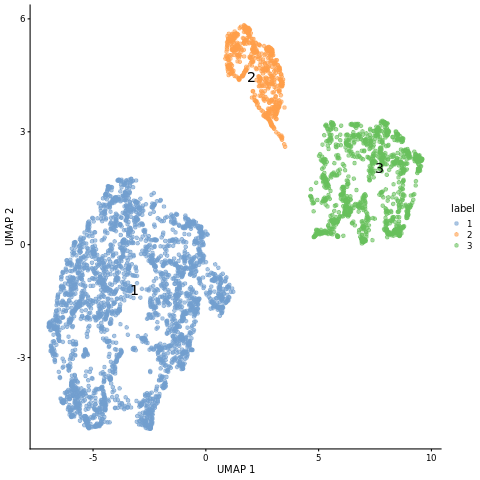

In [69]:
%%R
colLabels(sce) <- factor(clust.kmeans$cluster)
plotReducedDim(sce, "UMAP", colour_by="label",text_by="label")
#%%R
#colLabels(sce) <- nn.clusters
#plotReducedDim(sce, "UMAP", colour_by="label")


In [70]:
%%R
marker.info <- scoreMarkers(sce, colLabels(sce))
marker.info

List of length 3
names(3): 1 2 3


In [71]:
%%R
chosen <- marker.info[["1"]]
ordered <- chosen[order(chosen$mean.AUC, decreasing=TRUE),]
head(ordered[,1:10]) # showing basic stats only, for brevity.

DataFrame with 6 rows and 10 columns
                     self.average other.average self.detected other.detected
                        <numeric>     <numeric>     <numeric>      <numeric>
vsg-2-Tb427.BES40.22     4.002041      0.174653      1.000000      0.1014517
gene-Tb427.BES40.3       0.297487      0.121154      0.238374      0.1011593
Tb927.11.19810           1.422310      1.239242      0.808130      0.7533544
Tb927.5.810              1.906690      1.726824      0.903893      0.8737454
gene-Tb427.BES40.1       0.255997      0.118151      0.198760      0.0982699
Tb927.10.12850           0.948453      0.823835      0.640372      0.5786916
                     mean.logFC.cohen min.logFC.cohen median.logFC.cohen
                            <numeric>       <numeric>          <numeric>
vsg-2-Tb427.BES40.22         4.112600       3.6804019           4.112600
gene-Tb427.BES40.3           0.381406       0.2191700           0.381406
Tb927.11.19810               0.209124       0.1676342  

In [72]:
%%R
chosen <- marker.info[["2"]]
ordered <- chosen[order(chosen$mean.AUC, decreasing=TRUE),]
head(ordered[,1:10]) # showing basic stats only, for brevity.

DataFrame with 6 rows and 10 columns
               self.average other.average self.detected other.detected
                  <numeric>     <numeric>     <numeric>      <numeric>
Tb927.6.1520       1.113427      0.893357      0.696013       0.598394
Tb927.11.11680     0.915775      0.711969      0.616279       0.530093
Tb927.10.7410      0.503927      0.343912      0.406977       0.291034
Tb927.6.2790       0.693315      0.537057      0.506645       0.404881
Tb927.7.5940       0.644599      0.481054      0.480066       0.381534
Tb927.10.12700     0.439439      0.289407      0.360465       0.253814
               mean.logFC.cohen min.logFC.cohen median.logFC.cohen
                      <numeric>       <numeric>          <numeric>
Tb927.6.1520           0.261612       0.0915042           0.261612
Tb927.11.11680         0.259902       0.2083816           0.259902
Tb927.10.7410          0.260059       0.2311911           0.260059
Tb927.6.2790           0.220918       0.0727099           0.

In [73]:
%%R
chosen <- marker.info[["3"]]
ordered <- chosen[order(chosen$mean.AUC, decreasing=TRUE),]
head(ordered[,1:10]) # showing basic stats only, for brevity.

DataFrame with 6 rows and 10 columns
                     self.average other.average self.detected other.detected
                        <numeric>     <numeric>     <numeric>      <numeric>
vsg-6-Tb427.BES15.12     4.616327      0.140827      0.990317      0.0779120
Tb927.3.3270             1.262210      0.695742      0.733275      0.4838038
Tb927.11.880             1.162192      0.652257      0.662852      0.4393937
Tb927.10.8940            1.293636      0.902728      0.726232      0.5727275
Tb927.6.4280             0.503530      0.193231      0.351232      0.1532748
Tb927.10.14140           0.344108      0.105884      0.273768      0.0906077
                     mean.logFC.cohen min.logFC.cohen median.logFC.cohen
                            <numeric>       <numeric>          <numeric>
vsg-6-Tb427.BES15.12         4.845691        4.648262           4.845691
Tb927.3.3270                 0.660219        0.494969           0.660219
Tb927.11.880                 0.569930        0.366296  

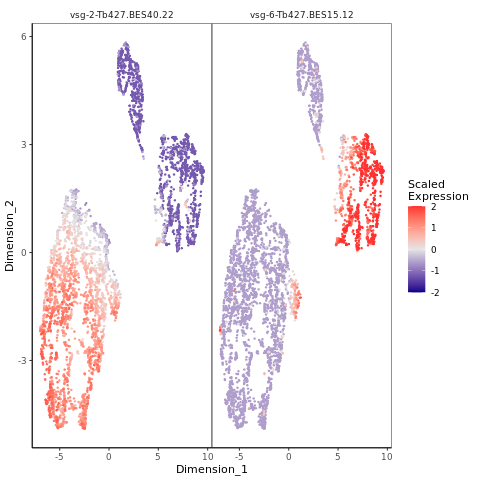

In [74]:
%%R
library(celda)
umap <- reducedDim(sce, "UMAP")
plotDimReduceFeature(as.matrix(logcounts(sce)),
    dim1 = umap[, 1],
    dim2 = umap[, 2],
    features = c('vsg-2-Tb427.BES40.22', 'vsg-6-Tb427.BES15.12'),
    exactMatch = TRUE)

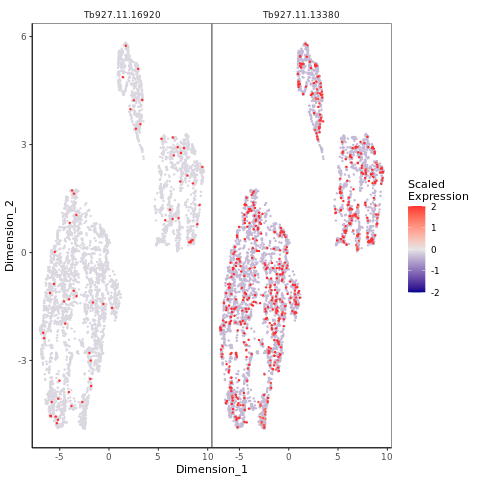

In [75]:
%%R
library(celda)
umap <- reducedDim(sce, "UMAP")
plotDimReduceFeature(as.matrix(logcounts(sce),zscore=FALSE),
    dim1 = umap[, 1],
    dim2 = umap[, 2],
    features = c('Tb927.11.16920', 'Tb927.11.13380'),
    exactMatch = TRUE)


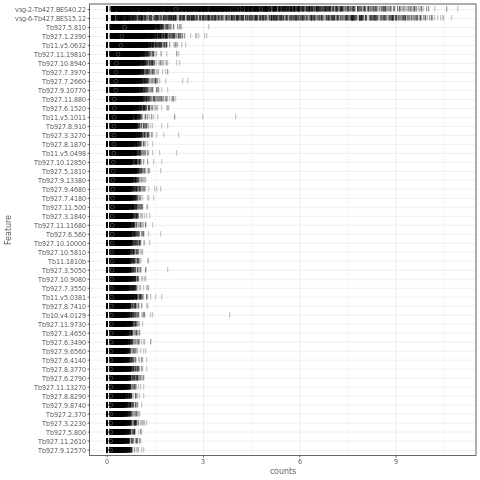

In [76]:
%%R
plotHighestExprs(sce, exprs_values = "counts")

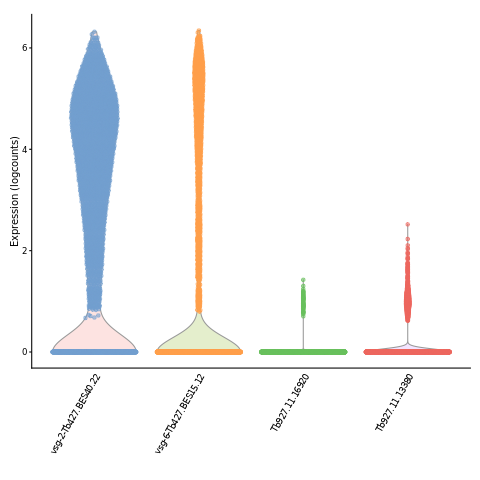

In [77]:
%%R
names = c('vsg-2-Tb427.BES40.22', 'vsg-6-Tb427.BES15.12', 'Tb927.11.16920', 'Tb927.11.13380')
plotExpression(sce, names,)

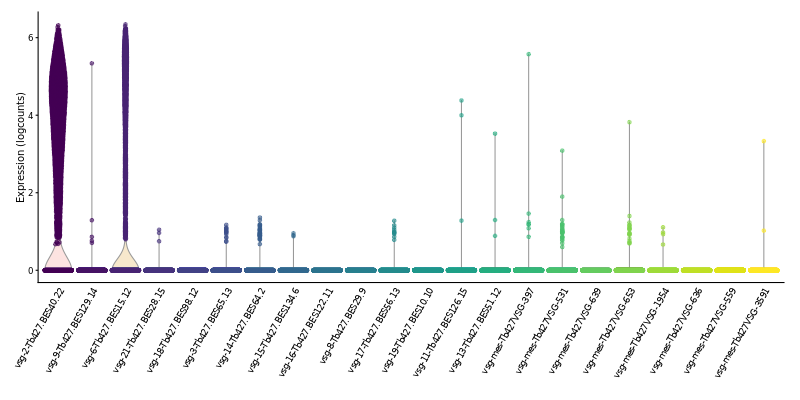

In [78]:
%%R -w 800 -h 400

names = c('vsg-2-Tb427.BES40.22', 
          'vsg-6-Tb427.BES15.12',
          
          'Tb927.11.16920', 
          'Tb927.11.13380')
plotExpression(sce, rownames(sce[which(is.vsg2), ]))

In [79]:
%%R
# PercentAbove function to environment
PercentAbove <- function(x, threshold) {
  return(length(x = x[x > threshold]) / length(x = x))
}
names = c('vsg-2-Tb427.BES40.22', 'vsg-6-Tb427.BES15.12', 'Tb927.11.16920', 'Tb927.11.13380')

# Pull data on features of interest
data.features <- FetchData(object = CreateSeuratObject(counts(sce)), vars = names)
# Calculate average expression (NOTE can also be done simply using `AverageExpression` function.)
avg.exp <- apply(X = data.features, MARGIN = 2, FUN = function(x) {return(mean(x = expm1(x = x)))})
# Calculate % expressing
pct.exp <- apply(X = data.features, MARGIN = 2, FUN = PercentAbove, threshold = 0)
# combine the data
combined_avg_pct <- list(avg.exp = avg.exp, pct.exp = pct.exp)
combined_avg_pct

$avg.exp
vsg-2-Tb427.BES40.22 vsg-6-Tb427.BES15.12       Tb927.11.16920 
        1.473399e+38         1.178979e+37         2.221437e-02 
      Tb927.11.13380 
        2.969803e-01 

$pct.exp
vsg-2-Tb427.BES40.22 vsg-6-Tb427.BES15.12       Tb927.11.16920 
          0.66925232           0.30446025           0.01292825 
      Tb927.11.13380 
          0.12303383 



In [80]:
%%R
marker.info <- scoreMarkers(sce, colLabels(sce))
marker.info

List of length 3
names(3): 1 2 3


In [81]:
%%R
chosen <- marker.info[["4"]]
ordered <- chosen[order(chosen$mean.AUC, decreasing=TRUE),]
head(ordered[,1:4]) # showing basic stats only, for brevity.

R[write to console]: Error in order(..., decreasing = decreasing) : argument 1 is not a vector

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In xy.coords(x, y, xlabel, ylabel, log) :
R[write to console]: 
 
R[write to console]:  2292 x values <= 0 omitted from logarithmic plot




Error in order(..., decreasing = decreasing) : argument 1 is not a vector


RInterpreterError: Failed to parse and evaluate line 'chosen <- marker.info[["4"]]\nordered <- chosen[order(chosen$mean.AUC, decreasing=TRUE),]\nhead(ordered[,1:4]) # showing basic stats only, for brevity.\n'.
R error message: 'Error in order(..., decreasing = decreasing) : argument 1 is not a vector'

In [ ]:
%%R
chosen <- marker.info[["5"]]
ordered <- chosen[order(chosen$mean.AUC, decreasing=TRUE),]
head(ordered[,1:4]) # showing basic stats only, for brevity.

In [ ]:
%%R
chosen <- marker.info[["1"]]
ordered <- chosen[order(chosen$mean.AUC, decreasing=TRUE),]
head(ordered[,1:4]) # showing basic stats only, for brevity.

In [ ]:
%%R
chosen <- marker.info[["6"]]
ordered <- chosen[order(chosen$mean.AUC, decreasing=TRUE),]
head(ordered[,1:4]) # showing basic stats only, for brevity.

In [ ]:
%%R
chosen <- marker.info[["1"]]
ordered <- chosen[order(chosen$mean.AUC, decreasing=TRUE),]
head(ordered[,1:4]) # showing basic stats only, for brevity.

In [74]:
%%R
chosen <- marker.info[["8"]]
ordered <- chosen[order(chosen$mean.AUC, decreasing=TRUE),]
head(ordered[,1:4]) # showing basic stats only, for brevity.

DataFrame with 6 rows and 4 columns
                     self.average other.average self.detected other.detected
                        <numeric>     <numeric>     <numeric>      <numeric>
vsg-2-Tb427.BES40.22      5.00558      2.264156      1.000000       0.612824
Tb927.11.880              2.03697      0.760332      0.941606       0.485607
rRNA-Tb927.2.1975         6.30977      5.527995      1.000000       0.995363
Tb927.1.2390              2.43454      1.408038      0.981752       0.724868
Tb927.6.4280              0.96661      0.259878      0.598540       0.201245
Tb927.9.4680              1.39595      0.758424      0.839416       0.543082


# Extract VSGs

In [124]:
%%R
sce_vsg <- sce[which(is.vsg2), ]

#is.vsg19 <- grepl("vsg-19-", rownames(sce_vsg))
#sce_vsg <- sce_vsg[which(!is.vsg19), ]

sce_vsg

class: SingleCellExperiment 
dim: 22 4641 
metadata(0):
assays(2): counts logcounts
rownames(22): vsg-2-Tb427.BES40.22 vsg-9-Tb427.BES129.14 ...
  vsg-mes-Tb427VSG-559 vsg-mes-Tb427VSG-3591
rowData names(0):
colnames(4641): AAACCCAAGACACACG-1 AAACCCAAGCTTTCCC-1 ...
  TTTGTTGAGGCCGCTT-1 TTTGTTGTCCAAGAGG-1
colData names(21): discard_mito discard_sum ... sizeFactor label
reducedDimNames(2): PCA UMAP
mainExpName: NULL
altExpNames(0):


# Save datasets

In [125]:
%%R
test <- as.matrix(logcounts(sce))
write.table(test,file=paste(path_to,"decont_dense_log.csv",sep=''),sep = ",")

test <- as.matrix(counts(sce))
write.table(test,file=paste(path_to,"decont_dense.csv",sep=''),sep = ",")

test <- as.matrix(counts(sce_vsg))
write.table(test,file=paste(path_to,"decont_dense_vsg.csv",sep=''),sep = ",")

test <- as.matrix(logcounts(sce_vsg))
write.table(test,file=paste(path_to,"decont_dense_log_vsg.csv",sep=''),sep = ",")

In [129]:
#!rm VSG-2_VSG-6_1_count6/outs//decont_dense.csv.gz

In [130]:
!gzip $path_to"/decont_dense_log.csv"
!gzip $path_to"/decont_dense.csv"

In [5]:
df = pd.read_csv(path_to+"decont_dense.csv.gz")

In [132]:
#vex1
((df.loc['Tb927.11.16920'][df.loc['Tb927.11.16920']>0]).shape, 
 df.loc['Tb927.11.16920'].shape,
 ((df.loc['Tb927.11.16920'][df.loc['Tb927.11.16920']>0]).shape[0]*100)/df.loc['Tb927.11.16920'].shape[0])

((60,), (4641,), 1.292824822236587)

In [133]:
#vex2
((df.loc['Tb927.11.13380'][df.loc['Tb927.11.13380']>0]).shape,
df.loc['Tb927.11.13380'].shape,
 ((df.loc['Tb927.11.13380'][df.loc['Tb927.11.13380']>0]).shape[0]*100)/df.loc['Tb927.11.13380'].shape[0])

((571,), (4641,), 12.303382891618186)

In [134]:
(df.loc['Tb927.11.16920'][df.loc['Tb927.11.16920']>0].value_counts(),
df.loc['Tb927.11.13380'][df.loc['Tb927.11.13380']>0].value_counts())

(1    60
 Name: Tb927.11.16920, dtype: int64,
 1    505
 2     59
 3      7
 Name: Tb927.11.13380, dtype: int64)

In [12]:
#df.iloc[:,120].value_counts()

0     11004
1       411
2        61
3        11
4         5
22        1
10        1
36        1
8         1
5         1
Name: AAGAACAAGAACTTCC-1, dtype: int64

# Visualize VSG coexpression

In [235]:
df = pd.read_csv(path_to+"decont_dense_vsg.csv")
print(df.shape)
df.T.head()

(22, 4656)


,vsg-2-Tb427.BES40.22,vsg-9-Tb427.BES129.14,vsg-6-Tb427.BES15.12,vsg-21-Tb427.BES28.15,vsg-18-Tb427.BES98.12,vsg-3-Tb427.BES65.13,vsg-14-Tb427.BES64.2,vsg-15-Tb427.BES134.6,vsg-16-Tb427.BES122.11,vsg-8-Tb427.BES29.9,...,vsg-11-Tb427.BES126.15,vsg-13-Tb427.BES51.12,vsg-mes-Tb427VSG-397,vsg-mes-Tb427VSG-531,vsg-mes-Tb427VSG-639,vsg-mes-Tb427VSG-653,vsg-mes-Tb427VSG-1954,vsg-mes-Tb427VSG-636,vsg-mes-Tb427VSG-559,vsg-mes-Tb427VSG-3591
AAACCCAAGACACACG-1,0,0,38,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCCAAGCTTTCCC-1,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCCACAAGCTACT-1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCCATCCTCTGCA-1,38,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACGAAGTACAAGTA-1,4,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='vsg-2-Tb427.BES40.22', ylabel='vsg-6-Tb427.BES15.12'>

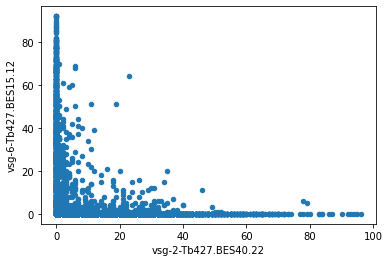

In [236]:
df.T.plot(x='vsg-2-Tb427.BES40.22',y='vsg-6-Tb427.BES15.12',kind='scatter')

<AxesSubplot:xlabel='vsg-2-Tb427.BES40.22', ylabel='vsg-6-Tb427.BES15.12'>

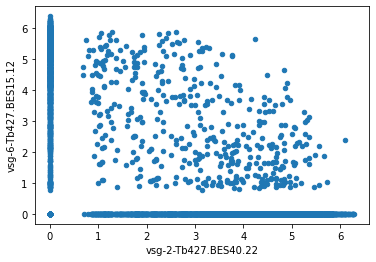

In [237]:
df = pd.read_csv(path_to+"decont_dense_log_vsg.csv")
df.T.plot(x='vsg-2-Tb427.BES40.22', y='vsg-6-Tb427.BES15.12',kind='scatter')

In [238]:
df.T[df.T['vsg-2-Tb427.BES40.22']==0].shape

(1537, 22)

In [239]:
df.head()

,AAACCCAAGACACACG-1,AAACCCAAGCTTTCCC-1,AAACCCACAAGCTACT-1,AAACCCATCCTCTGCA-1,AAACGAAGTACAAGTA-1,AAACGAATCAAGCTGT-1,AAACGAATCGTGGGAA-1,AAACGCTAGACTCGAG-1,AAACGCTAGAGTGTTA-1,AAACGCTGTTCGATTG-1,...,TTTGGTTCACTGGAAG-1,TTTGGTTCAGATAAAC-1,TTTGGTTCAGTGGTGA-1,TTTGGTTCATTGAGGG-1,TTTGGTTGTTAGAGAT-1,TTTGGTTTCCTCACTG-1,TTTGGTTTCGCCAGAC-1,TTTGGTTTCGGTCATA-1,TTTGTTGAGGCCGCTT-1,TTTGTTGTCCAAGAGG-1
vsg-2-Tb427.BES40.22,0.000000,4.409463,2.614481,5.03096,2.344919,0,1.245415,3.363913,4.35967,4.740156,...,1.148983,2.441825,0.000000,0.00000,3.148735,0.000000,4.15959,0,4.794258,0
vsg-9-Tb427.BES129.14,0.000000,0.000000,0.000000,0.00000,0.000000,0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0,0.000000,0
vsg-6-Tb427.BES15.12,5.652085,0.000000,0.000000,0.00000,2.021565,0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,5.238286,5.63817,1.857155,5.575982,0.00000,0,0.000000,0
vsg-21-Tb427.BES28.15,0.000000,0.000000,0.000000,0.00000,0.000000,0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0,0.000000,0
vsg-18-Tb427.BES98.12,0.000000,0.000000,0.000000,0.00000,0.000000,0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0,0.000000,0


In [161]:
#fold_change = df.T['vsg-2-Tb427.BES40.22'] - df.T['vsg-6-Tb427.BES4.11']
#fold_change.sort_values().plot()

In [162]:
#df[df>10]=0
#df.T.head()

In [163]:
#df[df>1]=1
#df.T.head()

In [164]:
#df.sum(axis=1)>1

In [165]:
#import missingno as msno
#import numpy as np
#msno.matrix(df.replace(0, np.nan))


<AxesSubplot:>

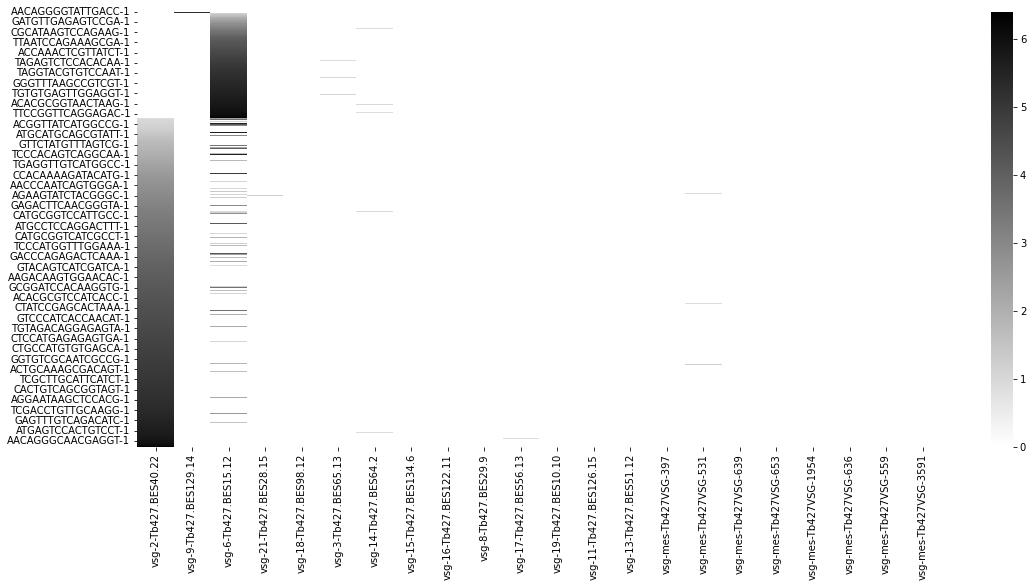

In [166]:
fig,ax=plt.subplots(figsize=(18,8))
sns.heatmap(df.T[df.T.sum(axis=1)>1].sort_values(
    ['vsg-2-Tb427.BES40.22','vsg-6-Tb427.BES15.12']),cmap='binary',ax=ax)

In [167]:
df.T[df.T.sum(axis=1)>1].shape

(4087, 22)

In [168]:
temp = df.loc[['vsg-2-Tb427.BES40.22','vsg-6-Tb427.BES15.12']]
temp = temp.T
temp = temp[temp.sum(axis=1)>1]
temp.shape

(4075, 2)

In [169]:
temp.head()

,vsg-2-Tb427.BES40.22,vsg-6-Tb427.BES15.12
AAACCCAAGACACACG-1,1.135011,5.537783
AAACCCAAGCTTTCCC-1,4.663524,0.000000
AAACCCACAAGCTACT-1,2.803017,0.000000
AAACCCATCCTCTGCA-1,5.139493,0.000000
AAACGAAGTACAAGTA-1,2.007343,2.007343


In [170]:
temp[temp>0]=1
temp.head()

,vsg-2-Tb427.BES40.22,vsg-6-Tb427.BES15.12
AAACCCAAGACACACG-1,1.0,1.0
AAACCCAAGCTTTCCC-1,1.0,0.0
AAACCCACAAGCTACT-1,1.0,0.0
AAACCCATCCTCTGCA-1,1.0,0.0
AAACGAAGTACAAGTA-1,1.0,1.0


In [171]:
temp.value_counts()

vsg-2-Tb427.BES40.22  vsg-6-Tb427.BES15.12
1.0                   0.0                     2632
0.0                   1.0                      987
1.0                   1.0                      456
dtype: int64

In [173]:
(456/(2632+987)*100)

12.600165791655154